First read and parse the data 

In [1]:
import xml.etree.ElementTree as ET

def parse_xml(xml_path):
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
        
        labels_per_image = {}
        
        for image in root.findall("image"):
            image_name = image.get("name")
            labels = []
            
            for poly in image.findall("polygon"):
                labels.append(poly.get("label"))
            
            labels_per_image[image_name] = labels
        
        return labels_per_image
        
    except ET.ParseError as e:
        print(f"XML parsing error: {e}")
        return {}
    except FileNotFoundError:
        print(f"XML file not found: {xml_path}")
        return {}
    except Exception as e:
        print(f"Unexpected error: {e}")
        return {}

def label_Y(labels_per_image):
    y_labels = {}
    for img, labels in labels_per_image.items():
        if "D_Building" in labels or "Debris" in labels:
            y_labels[img] = 1
        else:
            y_labels[img] = 0
    return y_labels

In [2]:
labels_per_image_train= parse_xml("../EIDSeg_Dataset/data/train/train.xml")
Y_train=label_Y(labels_per_image_train)
labels_per_image_test = parse_xml("../EIDSeg_Dataset/data/test/test.xml")
Y_test= label_Y(labels_per_image_test)


In [3]:
import os
import cv2
import numpy as np
def load_and_resize_images(images_folder, target_size=(64, 64)):
    X = []
    ordered_filenames = []
    
    for filename in sorted(os.listdir(images_folder)):
        if filename.lower().endswith((".jpg", ".jpeg", ".png")):
            img_path = os.path.join(images_folder, filename)

            img = cv2.imread(img_path)
            if img is None:
                print(f"Warning: Cannot read {filename}, skipping.")
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_resized = cv2.resize(img, target_size)
            img_resized = img_resized.astype(np.float32) / 255.0

            X.append(img_resized)
            ordered_filenames.append(filename)

    X = np.array(X)

    print("Final X shape:", X.shape)
    return X, ordered_filenames


In [4]:
X_train_org ,ordered_filenames_train = load_and_resize_images("../EIDSeg_Dataset/data/train/images/default")

Final X shape: (2612, 64, 64, 3)


In [5]:
X_test_org, ordered_filenames_test = load_and_resize_images("../EIDSeg_Dataset/data/test/images/default")

Final X shape: (327, 64, 64, 3)


In [6]:
def build_label_array(ordered_filenames, labels_dict, default_value=0):
    """
    Build a label array in the same order as the given filenames.

    Params:
        ordered_filenames: list of filenames in desired order
        labels_dict: dictionary {filename: label}
        default_value: value to assign if filename has no label

    Returns:
        numpy array of shape (1, m)
    """
    Y = []

    for fname in ordered_filenames:
        if fname in labels_dict:
            Y.append(labels_dict[fname])
        else:
            print(f"Warning: No label found for {fname}, assigning {default_value}")
            Y.append(default_value)

    return np.array(Y).reshape(1, -1)

In [7]:
Y_train_org = build_label_array(ordered_filenames_train, Y_train)
Y_test_org  = build_label_array(ordered_filenames_test,  Y_test)


y = [1]


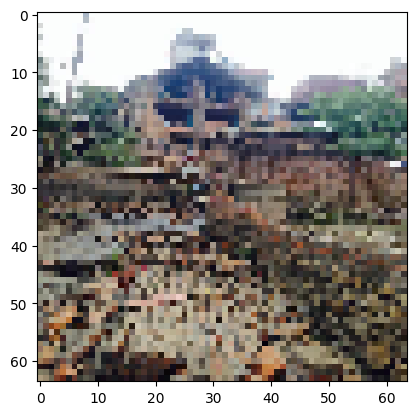

In [9]:
import matplotlib.pyplot as plt
# Example of a picture
index = 150
plt.imshow(X_train_org[index])
print ("y = " + str(Y_train_org[:, index]))


In [14]:
m_train = X_train_org.shape[0]
m_test = X_test_org.shape[0]
num_px =X_train_org.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(X_train_org.shape))
print ("train_set_y shape: " + str(Y_train_org.shape))
print ("test_set_x shape: " + str(X_test_org.shape))
print ("test_set_y shape: " + str(Y_test_org.shape))

Number of training examples: m_train = 2612
Number of testing examples: m_test = 327
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (2612, 64, 64, 3)
train_set_y shape: (1, 2612)
test_set_x shape: (327, 64, 64, 3)
test_set_y shape: (1, 327)


In [16]:
train_set_x_flatten=X_train_org.reshape(X_train_org.shape[0],-1).T
test_set_x_flatten=X_test_org.reshape(X_test_org.shape[0],X_test_org.shape[1]*X_test_org.shape[2]*X_test_org.shape[3]).T

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(Y_train_org.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(Y_test_org.shape))

train_set_x_flatten shape: (12288, 2612)
train_set_y shape: (1, 2612)
test_set_x_flatten shape: (12288, 327)
test_set_y shape: (1, 327)


In [19]:
def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias) of type float
    """
    w = np.zeros((dim,1))
    b = 0.0

    return w, b

def sigmoid(z):
    s=1/(1+np.exp(-z))    
    return s

In [20]:
def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    grads -- dictionary containing the gradients of the weights and bias
            (dw -- gradient of the loss with respect to w, thus same shape as w)
            (db -- gradient of the loss with respect to b, thus same shape as b)
    cost -- negative log-likelihood cost for logistic regression
    """
    
    m = X.shape[1]

    A= sigmoid(np.dot(w.T,X)+b)
    cost= Y*np.log(A)+(1-Y)*np.log(1-A)
    cost=np.sum(cost)
    cost/=-m
    dw=np.dot(X,(A-Y).T)
    db=np.sum(A-Y)
    dw/=m
    db/=m
    cost = np.squeeze(np.array(cost))

    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [26]:
import copy

def optimize(w, b, X, Y, num_iterations=100, learning_rate=0.009, print_cost=False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    """
    
    w = copy.deepcopy(w)
    b = copy.deepcopy(b)
    
    costs = []
    
    for i in range(num_iterations):
        grads, cost = propagate (w, b, X, Y)
                
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        w -= learning_rate*dw
        b -= learning_rate*db
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
            # Print the cost every 100 training iterations
            if print_cost:
                print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [27]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)
    
    A=sigmoid(np.dot(w.T,X)+b)
    
    for i in range(A.shape[1]):
        if A[0,i] > 0.5:
            Y_prediction[0,i] = 1
        else:
            Y_prediction[0,i] = 0
        
    
    return Y_prediction

In [28]:

def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to True to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    w=np.zeros((X_train.shape[0],1))
    b=0.0
    params, grads, costs = optimize(w ,b ,X_train ,Y_train ,num_iterations ,learning_rate ,print_cost)
    w=params["w"]
    b=params["b"]
    Y_prediction_test=predict(w,b,X_test)
    Y_prediction_train= predict(w,b,X_train)

    # Print train/test Errors
    if print_cost:
        print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
        print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [32]:
logistic_regression_model = model(train_set_x_flatten, Y_train_org, test_set_x_flatten, Y_test_org, num_iterations=2000, learning_rate=0.001, print_cost=True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.599500
Cost after iteration 200: 0.590629
Cost after iteration 300: 0.584475
Cost after iteration 400: 0.579510
Cost after iteration 500: 0.575214
Cost after iteration 600: 0.571359
Cost after iteration 700: 0.567826
Cost after iteration 800: 0.564538
Cost after iteration 900: 0.561447
Cost after iteration 1000: 0.558515
Cost after iteration 1100: 0.555717
Cost after iteration 1200: 0.553032
Cost after iteration 1300: 0.550446
Cost after iteration 1400: 0.547945
Cost after iteration 1500: 0.545520
Cost after iteration 1600: 0.543163
Cost after iteration 1700: 0.540868
Cost after iteration 1800: 0.538628
Cost after iteration 1900: 0.536440
train accuracy: 74.5405819295559 %
test accuracy: 73.70030581039755 %
